## load and process data for plotting PDFs of temperatures, hours lost in forested vs deforested locations

### define data paths
#### all data available on Zenodo at: 10.5281/zenodo.5707740

In [1]:
data_path_biome     =    '/Users/lukeaparsons/Documents/Data/Observations/biome/'
data_path_cover     =    '/Users/lukeaparsons/Documents/Data/Observations/Hansen/'
data_path_temp     =    '/Users/lukeaparsons/Documents/Data/Observations/MODIS/three_hottest_months/'
data_path_hours     =    '/Users/lukeaparsons/Documents/Data/Observations/MODIS/hours_lost/'
data_path_warmed    =    '/Users/lukeaparsons/Documents/Data/Observations/MODIS/CMIP5_projection/'
data_path_pop_gpw   =    '/Users/lukeaparsons/Documents/Data/Observations/population/GPW_pop/'


In [2]:
# Import modules

import warnings
warnings.filterwarnings('ignore')
import os
import glob
import numpy as np
import xarray as xr
import xesmf as xe
from scipy import special #note this is used in Kjellstrom 2018 erf
import time as tm
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.basemap import Basemap, maskoceans
import matplotlib.cm as cm
import matplotlib as mpl

In [3]:
## define hours lost cutoff etc for analysis
HoursLost_Cutoff = 0 #set to 0.25 for plotting PDFs because so many tropical forest locations with no loss are zero

CoverThreshold = 75 #set forest cover threshold to 75% for forested areas

LossYearCutoff = 2003 #all loss must happen in or after this year bc this is when MODIS temperature obs start

regions = ['Americas','Africa','Asia']

## load biome data


In [4]:
for ri,region in enumerate(regions):
    vars()[str(region)+'_bio'] = xr.open_dataset(data_path_biome + str(region) + '_biome_mask.nc')
    if region == 'Americas':
        vars()[str(region)+'_biome'] = vars()[str(region)+'_bio']['americas_biome_mask']
    if region == 'Africa':
        vars()[str(region)+'_biome'] = vars()[str(region)+'_bio']['Feature_shp1']
    if region == 'Asia':
        vars()[str(region)+'_biome'] = vars()[str(region)+'_bio']['Feature_shp3']
        
    #remove non-number locations, keep 1 where biome
    vars()[str(region)+'_biome'].where(vars()[str(region)+'_biome'] == 1)
    
    print(region, 'first lat is: ',vars()[str(region)+'_biome'].lat[0].values, 'and first lon is: ',vars()[str(region)+'_biome'].lon[0].values)
    print('shape of ', region,' is ', vars()[str(region)+'_biome'].shape)

Americas first lat is:  29.99583333065268 and first lon is:  -119.99583332255736
shape of  Americas  is  (7200, 10320)
Africa first lat is:  29.9958333306271 and first lon is:  -19.995833331537654
shape of  Africa  is  (7200, 9600)
Asia first lat is:  29.99583333065268 and first lon is:  60.004166661278134
shape of  Asia  is  (7200, 14400)


## load forest cover, loss, etc data


In [5]:

for ri,region in enumerate(regions):
    
    #tree cover
    vars()['TreeCover_' + str(region)] = xr.open_dataset(data_path_cover + str(region) + '_treecover.nc')
    vars()['TreeCover_' + str(region)] = vars()['TreeCover_' + str(region)].rename({'Lon': 'lon','Lat': 'lat',})
    vars()['TreeCover_' + str(region)] = vars()['TreeCover_' + str(region)].sortby('lat', ascending=False)
    print('before reassignment, ',region, 'first lat is: ',vars()['TreeCover_' + str(region)].lat[0].values, 'and first lon is: ',vars()['TreeCover_' + str(region)].lon[0].values)
    vars()['treecover_' + str(region)] = vars()['TreeCover_' + str(region)]['treecover']
    vars()['treecover_' + str(region)] = vars()['treecover_' + str(region)].where(vars()['treecover_' + str(region)] > 0)
    if region == 'Americas':
        vars()['treecover_' + str(region)] = vars()['treecover_' + str(region)].where(vars()['treecover_' + str(region)]['lon'] <= vars()[str(region) + '_biome']['lon'].max(dim='lon'), drop = 'True')
    #assign coordinates from biome mask
    vars()['treecover_' + str(region)] = vars()['treecover_' + str(region)].assign_coords(lon = vars()[str(region)+'_biome'].lon, lat = vars()[str(region)+'_biome'].lat)
    
    vars()['LossYear_' + str(region)] = xr.open_dataset(data_path_cover + str(region) + '_lossyear.nc')
    vars()['LossYear_' + str(region)] = vars()['LossYear_' + str(region)].rename({'Lon': 'lon','Lat': 'lat',})
    vars()['LossYear_' + str(region)] = vars()['LossYear_' + str(region)].sortby('lat', ascending=False)
    print('before reassignment, ',region, 'first lat is: ',vars()['LossYear_' + str(region)].lat[0].values, 'and first lon is: ',vars()['LossYear_' + str(region)].lon[0].values)
    vars()['lossyear_' + str(region)] = vars()['LossYear_' + str(region)]['lossyear']
    vars()['lossyear_' + str(region)] = vars()['lossyear_' + str(region)].where(vars()['lossyear_' + str(region)] > 0)
    vars()['lossyear_' + str(region)] = vars()['lossyear_' + str(region)] + 2000
    if region == 'Americas':
        vars()['lossyear_' + str(region)] = vars()['lossyear_' + str(region)].where(vars()['lossyear_' + str(region)]['lon'] <= vars()[str(region) + '_biome']['lon'].max(dim='lon'), drop = 'True')
    #assign coordinates from biome mask
    vars()['lossyear_' + str(region)] = vars()['lossyear_' + str(region)].assign_coords(lon = vars()[str(region)+'_biome'].lon, lat = vars()[str(region)+'_biome'].lat)
    
    vars()['Gain_' + str(region)] = xr.open_dataset(data_path_cover + str(region) + '_gain.nc')
    vars()['Gain_' + str(region)] = vars()['Gain_' + str(region)].rename({'Lon': 'lon','Lat': 'lat',})
    vars()['Gain_' + str(region)] = vars()['Gain_' + str(region)].sortby('lat', ascending=False)
    print('before reassignment, ',region, 'first lat is: ',vars()['Gain_' + str(region)].lat[0].values, 'and first lon is: ',vars()['Gain_' + str(region)].lon[0].values)
    vars()['gain_' + str(region)] = vars()['Gain_'+str(region)]['gain']
    vars()['gain_' + str(region)] = vars()['gain_' + str(region)].where(vars()['gain_' + str(region)] > 0)
    #lop off dataset if lon goes beyond other dataset
    if region == 'Americas':
        vars()['gain_' + str(region)] = vars()['gain_' + str(region)].where(vars()['gain_' + str(region)]['lon'] <= vars()[str(region) + '_biome']['lon'].max(dim='lon'), drop = 'True')
    #assign coordinates from biome mask
    vars()['gain_' + str(region)] = vars()['gain_' + str(region)].assign_coords(lon = vars()[str(region)+'_biome'].lon, lat = vars()[str(region)+'_biome'].lat)

    vars()['LON_Hansen_' + str(region)] = vars()['TreeCover_' + str(region)]['lon']
    vars()['LAT_Hansen_' + str(region)] = vars()['TreeCover_' + str(region)]['lat']
    
    print('shape of ', region,' is ', vars()['lossyear_' + str(region)].shape)
    

before reassignment,  Americas first lat is:  29.995833333333337 and first lon is:  -119.99583333333334
before reassignment,  Americas first lat is:  29.995833333333337 and first lon is:  -119.99583333333334
before reassignment,  Americas first lat is:  29.995833333333337 and first lon is:  -119.99583333333334
shape of  Americas  is  (7200, 10320)
before reassignment,  Africa first lat is:  29.995833333333337 and first lon is:  -19.995833333333337
before reassignment,  Africa first lat is:  29.995833333333337 and first lon is:  -19.995833333333337
before reassignment,  Africa first lat is:  29.995833333333337 and first lon is:  -19.995833333333337
shape of  Africa  is  (7200, 9600)
before reassignment,  Asia first lat is:  29.995833333333337 and first lon is:  60.00416666666667
before reassignment,  Asia first lat is:  29.995833333333337 and first lon is:  60.00416666666667
before reassignment,  Asia first lat is:  29.995833333333337 and first lon is:  60.00416666666667
shape of  Asia 

## load 3 hottest months temperature data differences

In [6]:
for ri,region in enumerate(regions):
    vars()['temp_'+str(region)] = xr.open_dataset(data_path_temp + 'three_hottest_months_max_temp_' + str(region) + '_difference_2018_minus_2003.nc');
    vars()['temp_'+str(region)] = vars()['temp_'+str(region)].rename({'Lon': 'lon','Lat': 'lat',})
    print('before reassignment, ',str(region), 'first lat is: ',vars()['temp_'+str(region)].lat[0].values, 'and first lon is: ',vars()['temp_'+str(region)].lon[0].values)
    vars()['temp_'+str(region)] = vars()['temp_'+str(region)].assign_coords(lon = vars()[str(region)+'_biome'].lon, lat = vars()[str(region)+'_biome'].lat)
    
    vars()['temp_diff_'+str(region)] = vars()['temp_'+str(region)]['temperature']

    print('shape of ', region,' is ', vars()['temp_diff_'+str(region)].shape)

before reassignment,  Americas first lat is:  29.995833330639627 and first lon is:  -119.99583332255736
shape of  Americas  is  (7200, 10320)
before reassignment,  Africa first lat is:  29.995833330639627 and first lon is:  -19.995833331537654
shape of  Africa  is  (7200, 9600)
before reassignment,  Asia first lat is:  29.995833330639627 and first lon is:  60.004166661278134
shape of  Asia  is  (7200, 14400)


##  load hours lost 2018-2003, subtract to calculate change in hours lost for all locations



In [7]:
for ri,region in enumerate(regions):
    vars()[str(region) + '_2003'] = xr.open_dataset(data_path_hours + 'hours_lost_' + str(region) + '_2003.nc', decode_times=False);
    vars()[str(region) + '_2003'] = vars()[str(region) + '_2003'].rename({'Lon': 'lon','Lat': 'lat',})
    print('before reassignment, ',region, 'first lat is: ',vars()[str(region) + '_2003'].lat[0].values, 'and first lon is: ',vars()[str(region) + '_2003'].lon[0].values)
    vars()[str(region) + '_2003'] = vars()[str(region) + '_2003'].assign_coords(lon = vars()[str(region)+'_biome'].lon, lat = vars()[str(region)+'_biome'].lat)

    vars()[str(region) + '_2018'] = xr.open_dataset(data_path_hours + 'hours_lost_' + str(region) + '_2018.nc', decode_times=False);
    vars()[str(region) + '_2018'] = vars()[str(region) + '_2018'].rename({'Lon': 'lon','Lat': 'lat',})
    print('before reassignment, ',region, 'first lat is: ',vars()[str(region) + '_2018'].lat[0].values, 'and first lon is: ',vars()[str(region) + '_2018'].lon[0].values)
    vars()[str(region) + '_2018'] = vars()[str(region) + '_2018'].assign_coords(lon = vars()[str(region)+'_biome'].lon, lat = vars()[str(region)+'_biome'].lat)
    
    vars()['hours_lost_' + str(region) + '_2003'] = vars()[str(region) + '_2003']['hours_lost']
    vars()['hours_lost_' + str(region) + '_2018'] = vars()[str(region) + '_2018']['hours_lost']
    
    vars()['hours_lost_difference_' + str(region)] = vars()['hours_lost_' + str(region) + '_2018'] - vars()['hours_lost_' + str(region) + '_2003']
    
    vars()['LON_MODIS_' + str(region)] = vars()[str(region) + '_2003']['lon']
    vars()['LAT_MODIS_' + str(region)] = vars()[str(region) + '_2003']['lat']
    
    print('shape of ', region,' is ', vars()['hours_lost_difference_' + str(region)].shape)


before reassignment,  Americas first lat is:  29.995833330639627 and first lon is:  -119.99583332255736
before reassignment,  Americas first lat is:  29.995833330639627 and first lon is:  -119.99583332255736
shape of  Americas  is  (7200, 10320)
before reassignment,  Africa first lat is:  29.995833330639627 and first lon is:  -19.995833331537654
before reassignment,  Africa first lat is:  29.995833330639627 and first lon is:  -19.995833331537654
shape of  Africa  is  (7200, 9600)
before reassignment,  Asia first lat is:  29.995833330639627 and first lon is:  60.004166661278134
before reassignment,  Asia first lat is:  29.995833330639627 and first lon is:  60.004166661278134
shape of  Asia  is  (7200, 14400)


## load global warming projections of hours lost

In [8]:
gwfs = ['10','15','20']

for ri,region in enumerate(regions):
    
    for gi,gwf in enumerate(gwfs):

        vars()[str(region) + '_gwf'+str(gwf)] = xr.open_dataset(data_path_warmed + str(region) + '_hours_lost_gwf' + str(gwf) + '.nc')
        vars()[str(region) + '_gwf'+str(gwf)] = vars()[str(region) + '_gwf'+str(gwf)].rename({'Lon': 'lon','Lat': 'lat',})
        print('before reassignment, ',region, 'first lat is: ',vars()[str(region) + '_gwf'+str(gwf)].lat[0].values, 'and first lon is: ',vars()[str(region) + '_gwf'+str(gwf)].lon[0].values)
        vars()[str(region) + '_gwf'+str(gwf)] = vars()[str(region) + '_gwf'+str(gwf)].assign_coords(lon = vars()[str(region)+'_biome'].lon, lat = vars()[str(region)+'_biome'].lat)
        
        vars()['hours_lost_' + str(region) + '_gwf' + str(gwf)] = vars()[str(region) + '_gwf'+str(gwf)]['temperature']
        vars()['hours_lost_' + str(region) + '_gwf' + str(gwf)] = vars()['hours_lost_' + str(region) + '_gwf' + str(gwf)].where(vars()['hours_lost_' + str(region) + '_gwf' + str(gwf)] < 24)
        vars()['hours_lost_' + str(region) + '_gwf' + str(gwf)] = vars()['hours_lost_' + str(region) + '_gwf' + str(gwf)].where(vars()['hours_lost_' + str(region) + '_gwf' + str(gwf)] > 0)
        
        #now mask data where less than the hours lost cutoff defined above
        vars()['hours_lost_' + str(region) + '_gwf' + str(gwf)] = vars()['hours_lost_' + str(region) + '_gwf' + str(gwf)].where(vars()['hours_lost_' + str(region) + '_gwf' + str(gwf)] > HoursLost_Cutoff)
        
        print('shape of ', region,' is ', vars()['hours_lost_' + str(region) + '_gwf' + str(gwf)].shape)


before reassignment,  Americas first lat is:  29.995833330639627 and first lon is:  -119.99583332255736
shape of  Americas  is  (7200, 10320)
before reassignment,  Americas first lat is:  29.995833330639627 and first lon is:  -119.99583332255736
shape of  Americas  is  (7200, 10320)
before reassignment,  Americas first lat is:  29.995833330639627 and first lon is:  -119.99583332255736
shape of  Americas  is  (7200, 10320)
before reassignment,  Africa first lat is:  29.995833330639627 and first lon is:  -19.995833331537654
shape of  Africa  is  (7200, 9600)
before reassignment,  Africa first lat is:  29.995833330639627 and first lon is:  -19.995833331537654
shape of  Africa  is  (7200, 9600)
before reassignment,  Africa first lat is:  29.995833330639627 and first lon is:  -19.995833331537654
shape of  Africa  is  (7200, 9600)
before reassignment,  Asia first lat is:  29.995833330639627 and first lon is:  60.004166661278134
shape of  Asia  is  (7200, 14400)
before reassignment,  Asia fir

## load GPW population data

In [9]:
for ri,region in enumerate(regions):

    vars()['Pop_' + str(region)] = xr.open_dataset(data_path_pop_gpw + str(region) + '_gpw_pop_2015.nc')
    vars()['Pop_' + str(region)] = vars()['Pop_' + str(region)].rename({'Longitude': 'lon','Latitude': 'lat',})
    print('before reassignment, ',region, 'first lat is: ',vars()['Pop_' + str(region)].lat[0].values, 'and first lon is: ',vars()['Pop_' + str(region)].lon[0].values)
    vars()['Pop_' + str(region)] = vars()['Pop_' + str(region)].assign_coords(lon = vars()[str(region)+'_biome'].lon, lat = vars()[str(region)+'_biome'].lat)
    
    vars()['population_' + str(region)] = vars()['Pop_' + str(region)]['population']
    vars()['population_' + str(region)] = vars()['population_' + str(region)].where(vars()['population_' + str(region)] > 0)

    print('shape of ', region,' is ', vars()['population_' + str(region)].shape)


before reassignment,  Americas first lat is:  29.995833333333334 and first lon is:  -119.99583333333334
shape of  Americas  is  (7200, 10320)
before reassignment,  Africa first lat is:  29.995833333333334 and first lon is:  -19.995833333333334
shape of  Africa  is  (7200, 9600)
before reassignment,  Asia first lat is:  29.995833333333334 and first lon is:  60.00416666666667
shape of  Asia  is  (7200, 14400)


## define masks


In [10]:
for ri,region in enumerate(regions):
    
    #mask where tree cover in 2000 doesn't meet threshold 
    vars()['mask_notreecover_' +str(region)] = vars()['treecover_' + str(region)].where(vars()['treecover_' + str(region)] >= CoverThreshold)
    
    #mask early loss year: mask where tree loss before cutoff year, keep where loss after cutoff year
    vars()['mask_earlylossyear_' +str(region)] = vars()['lossyear_' + str(region)].where( vars()['lossyear_' + str(region)] >= LossYearCutoff)
    
    #define mask for where any tree loss in dataset (e.g., any number after 1999)
    vars()['mask_anylosslocations_' +str(region)] = vars()['lossyear_' + str(region)].where( vars()['lossyear_' + str(region)] < 2000)    

    #mask where no tree gain, 1 where any gain
    vars()['mask_notreegain_'+str(region)] = vars()['gain_' + str(region)].where(vars()['gain_' + str(region)] > 0)

    #mask where any tree gain, 1 where no gain
    #vars()['mask_treegain_' + str(region)] = vars()['gain_' + str(region)].where((vars()['gain_' + str(region)] > 0))
    
    ## mask where tropical forest and where >75% hansen forest cover
    vars()['mask_no_biome_noHansen75p_' + str(region)] = (vars()[str(region) + '_biome'].where(vars()['treecover_' + str(region)] >= CoverThreshold))

## mask hours lost 2003, 2018 based on if forest, kept, lost, gained for PDFs

In [12]:
vars()['temp_diff_'+str(region)]
years = ['2003','2018']

for ri,region in enumerate(regions):
    
    for yi,year in enumerate(years):
        
        #mask out where no tropical forest biome, where tree cover doesn't meet threshold
        vars()[str(region) + '_forested_' + str(year)] = (
            vars()['hours_lost_' + str(region) + '_' + str(year)].where(vars()['mask_no_biome_noHansen75p_'+str(region)] > 0))
        
        #mask out where no tropical forest biome, where tree cover doesn't meet threshold
        #ALSO mask out where there is any loss (loss year is not nan)
        vars()[str(region) + '_forested_noloss_' + str(year)] = (vars()['hours_lost_' + str(region) + '_' + str(year)].where(vars()['mask_no_biome_noHansen75p_'+str(region)] > 0)) * xr.ufuncs.isnan(vars()['lossyear_' + str(region)])

        #mask out where no tropical forest biome, where tree cover doesn't meet threshold
        #ALSO mask out where there is any gain (gain year is not nan), as well as if there is early loss before year cutoff
        vars()[str(region) + '_forested_lost_nogain_' + str(year)] = (vars()['hours_lost_' + str(region) + '_' + str(year)].where(vars()['mask_no_biome_noHansen75p_'+str(region)] > 0)
                                                             * xr.ufuncs.isnan(vars()['gain_' + str(region)] ).where( vars()['lossyear_' + str(region)] >= LossYearCutoff) )

        #mask out where no tropical forest biome, where tree cover doesn't meet threshold
        #ALSO mask out where there is any gain (gain year is not nan), as well as if there is early loss before year cutoff        
        vars()[str(region) + '_forested_gained_nolost_' + str(year)] = (vars()['hours_lost_' + str(region) + '_' + str(year)].where(vars()['mask_no_biome_noHansen75p_'+str(region)] > 0)).where(vars()['gain_' + str(region)] > 0) * xr.ufuncs.isnan(vars()['lossyear_' + str(region)])
    

## mask temperature changes based on if forest, kept, lost, gained for histograms


In [13]:
for ri,region in enumerate(regions):   
    
    #mask out where no tropical forest biome, where tree cover doesn't meet threshold   
    vars()[str(region) + '_T_forested'] = (
            vars()['temp_diff_'+str(region)].where(vars()['mask_no_biome_noHansen75p_'+str(region)] > 0))   
    
    #mask out where no tropical forest biome, where tree cover doesn't meet threshold
    #ALSO mask out where there is any loss (loss year is not nan)
    vars()[str(region) + '_T_forested_noloss'] = (vars()['temp_diff_'+str(region)]
                                                               .where(vars()['mask_no_biome_noHansen75p_'+str(region)] > 0)) * xr.ufuncs.isnan(vars()['lossyear_' + str(region)])
    #mask out where no tropical forest biome, where tree cover doesn't meet threshold
    #ALSO mask out where there is any gain (gain year is not nan), as well as if there is early loss before year cutoff
    vars()[str(region) + '_T_forested_lost_nogain'] = (vars()['temp_diff_'+str(region)]
                                                                    .where(vars()['mask_no_biome_noHansen75p_'+str(region)] > 0)
                                                         * xr.ufuncs.isnan(vars()['gain_' + str(region)] ).where( vars()['lossyear_' + str(region)] >= LossYearCutoff) )

    #mask out where no tropical forest biome, where tree cover doesn't meet threshold
    #ALSO mask out where there is any gain (gain year is not nan), as well as if there is early loss before year cutoff        
    vars()[str(region) + '_T_forested_gained_nolost'] = (vars()['temp_diff_'+str(region)]
                                                                      .where(vars()['mask_no_biome_noHansen75p_'+str(region)] > 0)).where(vars()['gain_' + str(region)] > 0) * xr.ufuncs.isnan(vars()['lossyear_' + str(region)])


## now create variable for hours lost difference between the years: differences in hours lost in forested vs deforested areas

In [14]:
for ri,region in enumerate(regions):
    vars()[str(region) + '_forested'] = vars()[str(region) + '_forested_2018'] - vars()[str(region) + '_forested_2003']
    vars()[str(region) + '_forested_noloss'] = vars()[str(region) + '_forested_noloss_2018'] - vars()[str(region) + '_forested_noloss_2003']
    vars()[str(region) + '_forested_lost_nogain'] = vars()[str(region) + '_forested_lost_nogain_2018'] - vars()[str(region) + '_forested_lost_nogain_2003']
    vars()[str(region) + '_forested_gained_nolost'] = vars()[str(region) + '_forested_gained_nolost_2018'] - vars()[str(region) + '_forested_gained_nolost_2003']
  


## plot the PDFs for each region for change in afternoon temperatures 2003-2018: Figure 1b

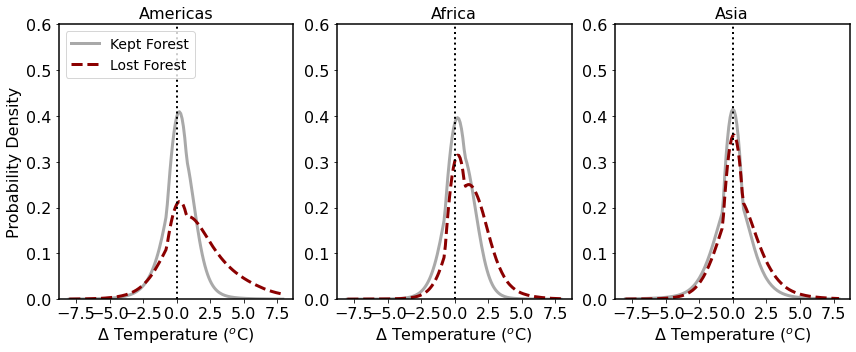

In [17]:
#Figure 1b

fsize = 16
lwidth = 3

X_plot = np.arange(-8,8,0.1)
X_plot = np.reshape(X_plot,(len(X_plot),1))

fig = plt.figure(figsize=(12,5))

for ri,region in enumerate(regions):
    ax = plt.subplot(1,3,ri+1)
    X = np.reshape(vars()[str(region) + '_T_forested_noloss'].values,
               (vars()[str(region) + '_T_forested_noloss'].shape[0]*vars()[str(region) + '_T_forested_noloss'].shape[1],1))
    X = X[~np.isnan(X)]
    X = np.reshape(X,(len(X),1))
    kde = KernelDensity(kernel="epanechnikov", bandwidth=0.75).fit(X)
    log_dens = kde.score_samples(X_plot)
    if ri == 0:
        plt.plot(X_plot[:, 0], np.exp(log_dens), linewidth = lwidth, color="darkgrey",label='Kept Forest')
        plt.legend()
    else:
        plt.plot(X_plot[:, 0], np.exp(log_dens), linewidth = lwidth, color="darkgrey")


    X = np.reshape(vars()[str(region) + '_T_forested_lost_nogain'].values,
               (vars()[str(region) + '_T_forested_lost_nogain'].shape[0]*vars()[str(region) + '_T_forested_lost_nogain'].shape[1],1))
    X = X[~np.isnan(X)]
    X = np.reshape(X,(len(X),1))
    kde = KernelDensity(kernel="epanechnikov", bandwidth=0.75).fit(X)
    log_dens = kde.score_samples(X_plot)
    if ri == 0:
        plt.plot(X_plot[:, 0], np.exp(log_dens),linestyle='--', linewidth = lwidth, color="darkred",label='Lost Forest')
        plt.legend(loc = 'upper left', fontsize=fsize-2)
    else:
        plt.plot(X_plot[:, 0], np.exp(log_dens),linestyle='--', linewidth = lwidth, color="darkred")
    plt.axvline(x=0,linewidth=2,linestyle=':',color='k')
    plt.ylim([0,0.6])
    plt.xticks(fontsize=fsize)
    plt.yticks(fontsize=fsize)
    plt.xlabel('$\Delta$ Temperature ($^o$C)',fontsize=fsize)
    plt.title(region,fontsize=fsize)
    if ri == 0:
        plt.ylabel('Probability Density',fontsize=fsize)
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)
        
plt.tight_layout()

#plt.savefig('Figure1b_TempDiff_2003_2018_Forest_Deforested.tiff', format='tiff')

## now plot the PDFs for each region for change in hours lost 2003-2018: Figure 1c

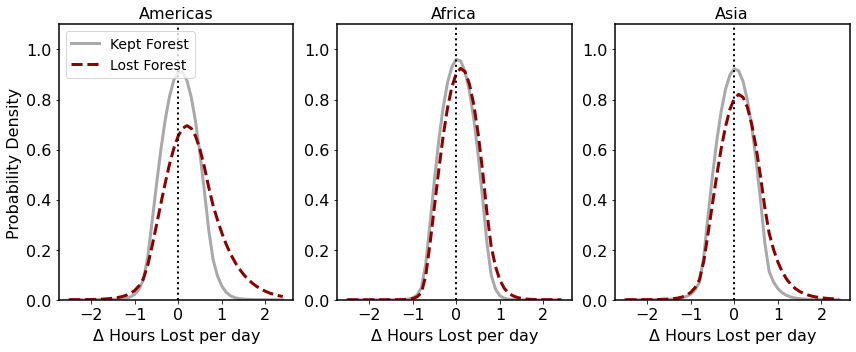

In [16]:
#Figure 1c

fsize = 16
lwidth = 3

X_plot = np.arange(-2.5,2.5,0.1)
X_plot = np.reshape(X_plot,(len(X_plot),1))

fig = plt.figure(figsize=(12,5))

for ri,region in enumerate(regions):
    ax = plt.subplot(1,3,ri+1)
    X = np.reshape(vars()[str(region) + '_forested_noloss'].values,
               (vars()[str(region) + '_forested_noloss'].shape[0]*vars()[str(region) + '_forested_noloss'].shape[1],1))
    X = X[~np.isnan(X)]
    X = np.reshape(X,(len(X),1))
    kde = KernelDensity(kernel="epanechnikov", bandwidth=0.75).fit(X)
    log_dens = kde.score_samples(X_plot)
    if ri == 0:
        plt.plot(X_plot[:, 0], np.exp(log_dens), linewidth = lwidth, color="darkgrey",label='Kept Forest')
    else:
        plt.plot(X_plot[:, 0], np.exp(log_dens), linewidth = lwidth, color="darkgrey")


    X = np.reshape(vars()[str(region) + '_forested_lost_nogain'].values,
               (vars()[str(region) + '_forested_lost_nogain'].shape[0]*vars()[str(region) + '_forested_lost_nogain'].shape[1],1))
    X = X[~np.isnan(X)]
    X = np.reshape(X,(len(X),1))
    kde = KernelDensity(kernel="epanechnikov", bandwidth=0.75).fit(X)
    log_dens = kde.score_samples(X_plot)
    if ri == 0:
        plt.plot(X_plot[:, 0], np.exp(log_dens),linestyle='--', linewidth = lwidth, color="darkred",label='Lost Forest')
        plt.legend(loc = 'upper left', fontsize=fsize-2)
    else:
        plt.plot(X_plot[:, 0], np.exp(log_dens),linestyle='--', linewidth = lwidth, color="darkred")
    plt.axvline(x=0,linewidth=2,linestyle=':',color='k')
    plt.ylim([0,1.1])
    plt.xticks(fontsize=fsize)
    plt.yticks(fontsize=fsize)
    plt.xlabel('$\Delta$ Hours Lost per day',fontsize=fsize)
    plt.title(region,fontsize=fsize)
    if ri == 0:
        plt.ylabel('Probability Density',fontsize=fsize)
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)
        
plt.tight_layout()

#plt.savefig('Figure1c_HoursLostDiff_2003_2018_Forest_Deforested.tiff', format='tiff')